In [1]:
import numpy as np
from numpy.fft import fft,ifft
from scipy.linalg import toeplitz
from scipy.sparse.linalg import minres, cg
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
NL = 4
n = NL
NA = NL+1
D = 1
d = D/10

In [3]:
atm = ceo.Atmosphere(0.15,25)

In [4]:
ngs = ceo.Source("V",resolution=(NA,NA))

In [5]:
aa = ceo.AaStatsMatrix(NL,atm,d,ngs)

In [6]:
q = np.hsplit(aa.cov.host().ravel(),4)

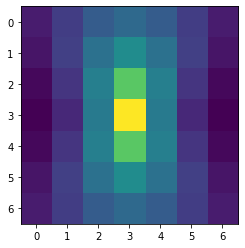

In [7]:
plt.imshow(q[-1].reshape(7,7))

In [8]:
n = 4
n_e = 2*n-1
e = np.arange(1,n_e**2+1)
#e

In [9]:
u = np.arange(n_e)-0.5*(n_e-1)
x,y = np.meshgrid(u,u)
e = np.hypot(x,y).ravel()

In [10]:
f = []
for e in np.hsplit(aa.cov.host().ravel(),4):

    t = []
    for _e_ in np.split(e,2*n-1):
        t += [toeplitz(_e_[n-1::-1],_e_[n-1:])]

    q = toeplitz(range(n-1,-1,-1),range(n-1,2*n-1))

    c = []
    for i in range(n):
        r = []
        for j in range(n):
            r += [t[q[i][j]]]
        c += [np.hstack(r)]
    f += [np.vstack(c)]

    #f

In [11]:
F = np.vstack([np.hstack(f[:2]),np.hstack(f[2:])])

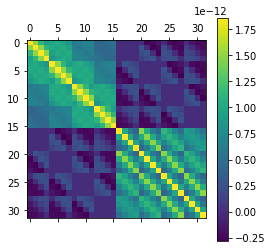

In [12]:
plt.matshow(F)
plt.colorbar()

In [13]:
u = np.ones((2*n**2,1),dtype=np.float32)

In [14]:
y0 = F@u

In [15]:
t = ceo.Btbt(2,2,n,n,aa.cov)

In [16]:
y = t.MVM(u.ravel())

In [17]:
np.sqrt(np.sum((y.host()-y0)**2))/y.size

2.868529239954067e-19

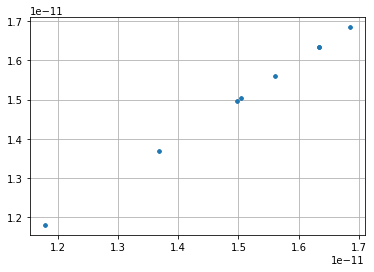

In [18]:
plt.plot(y0,y.host().ravel(),'.')
plt.grid()

In [19]:
y.host().ravel()

array([1.17952280e-11, 1.36826887e-11, 1.50445698e-11, 1.56049115e-11,
       1.49719265e-11, 1.63452047e-11, 1.68485677e-11, 1.63338093e-11,
       1.63338093e-11, 1.68485677e-11, 1.63452064e-11, 1.49719299e-11,
       1.56049115e-11, 1.50445698e-11, 1.36826904e-11, 1.17952289e-11,
       1.17952289e-11, 1.49719265e-11, 1.63338093e-11, 1.56049097e-11,
       1.36826895e-11, 1.63452047e-11, 1.68485677e-11, 1.50445698e-11,
       1.50445698e-11, 1.68485677e-11, 1.63452064e-11, 1.36826904e-11,
       1.56049115e-11, 1.63338093e-11, 1.49719299e-11, 1.17952289e-11],
      dtype=float32)

In [20]:
y0.ravel()

array([1.17952280e-11, 1.36826887e-11, 1.50445698e-11, 1.56049132e-11,
       1.49719299e-11, 1.63452064e-11, 1.68485711e-11, 1.63338093e-11,
       1.63338093e-11, 1.68485694e-11, 1.63452082e-11, 1.49719299e-11,
       1.56049132e-11, 1.50445715e-11, 1.36826904e-11, 1.17952297e-11,
       1.17952280e-11, 1.49719282e-11, 1.63338093e-11, 1.56049115e-11,
       1.36826895e-11, 1.63452082e-11, 1.68485711e-11, 1.50445715e-11,
       1.50445698e-11, 1.68485694e-11, 1.63452082e-11, 1.36826895e-11,
       1.56049115e-11, 1.63338093e-11, 1.49719299e-11, 1.17952297e-11],
      dtype=float32)

In [24]:
u = np.ones((2*n**2,1),dtype=np.float32)

In [25]:
u.sum()

32.0

In [26]:
t.NDFT
h = int(t.NDFT/2+1)
t_cov = np.split(t.cov.host(),[k*h for k in range(1,5)],1)
[_.shape for _ in t_cov]

[(1, 33), (1, 33), (1, 33), (1, 33), (1, 124)]

In [27]:
fft_cov = [fft(c.ravel(),t.NDFT)[:h] for c in np.hsplit(aa.cov.host().reshape(1,-1),4)]

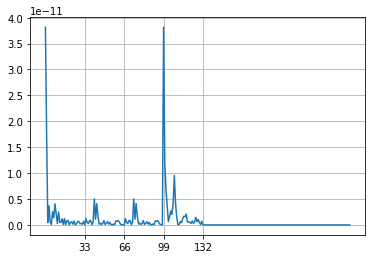

In [28]:
plt.plot(np.abs(t.cov.host().ravel()));
plt.xticks([k*h for k in range(1,5)])
plt.grid()

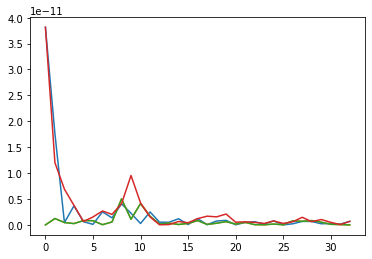

In [29]:
[ plt.plot(np.abs(c.ravel())) for c in t_cov[:-1]];


In [30]:
t_cov[4].sum()

0j

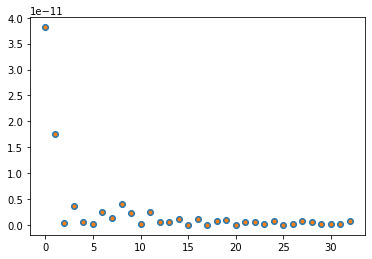

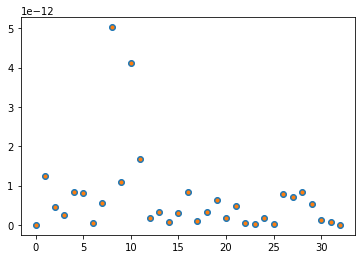

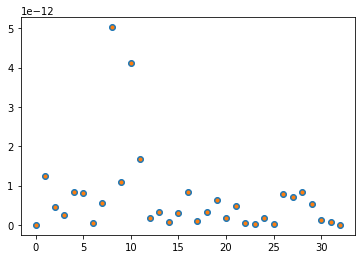

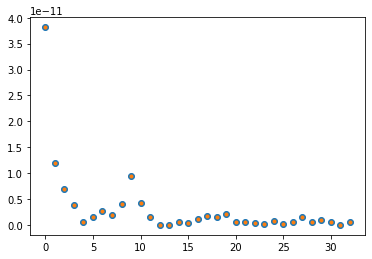

In [31]:
for id in range(4):
    plt.figure()
    plt.plot(np.abs(t_cov[id].ravel()),'o')
    plt.plot(np.abs(fft_cov[id].ravel()),'.')

In [32]:
t = ceo.Btbt(2,2,n,n,aa.cov)

In [33]:
t.NDFT,n

(64, 4)

In [34]:
t.mu.host()

array([[24, 23, 22, 21, 17, 16, 15, 14, 10,  9,  8,  7,  3,  2,  1,  0]],
      dtype=int32)

In [35]:
u.shape

(32, 1)

In [36]:
y = t.MVM(u.ravel(),step=1)

In [37]:
y = t.MVM(u.ravel(),step=2)

In [38]:
b = np.zeros(t.NDFT)
b[t.mu.host().ravel()] = u.ravel()[:16]
fft_b = fft(b)[:33]

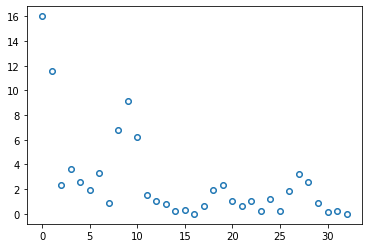

In [39]:
plt.plot(np.abs(t.b.host()).ravel()[:33],'o');
plt.plot(np.abs(fft_b.ravel()),'w.')

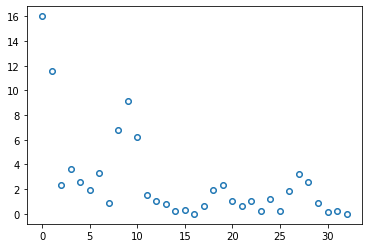

In [40]:
plt.plot(np.abs(t.b.host()).ravel()[33:66],'o');
plt.plot(np.abs(fft_b.ravel()),'w.')

In [41]:
y = t.MVM(u.ravel(),step=3)

In [42]:
fft_c = t.c.host()[0,:33]
q = np.hstack([fft_c,np.conj(fft_c[1:-1][::-1])])
yp_a = ifft(q,t.NDFT)

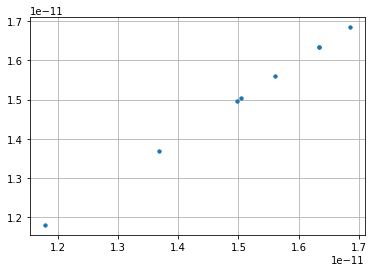

In [43]:
plt.plot(y0.ravel()[:16],np.real(yp_a[t.xi.host().ravel()]),'.')
plt.grid()

In [44]:
fft_c = t.c.host()[0,33:66]
q = np.hstack([fft_c,np.conj(fft_c[1:-1][::-1])])
yp_b = ifft(q,t.NDFT)

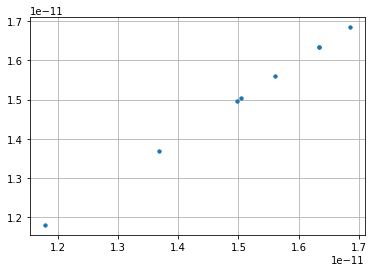

In [45]:
plt.plot(y0.ravel()[16:32],np.real(yp_b[t.xi.host().ravel()]),'.')
plt.grid()

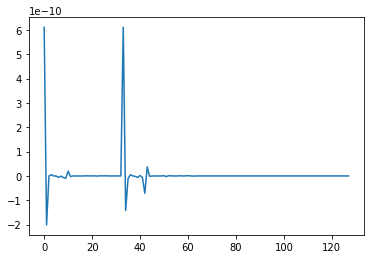

In [46]:
plt.plot(np.real(t.c.host()).ravel());

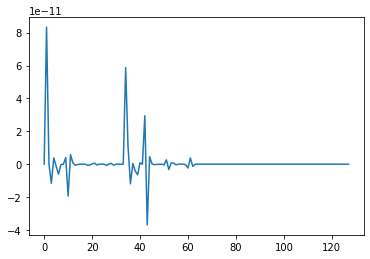

In [47]:
plt.plot(np.imag(t.c.host()).ravel());

In [48]:
y = t.MVM(u.ravel(),step=4)

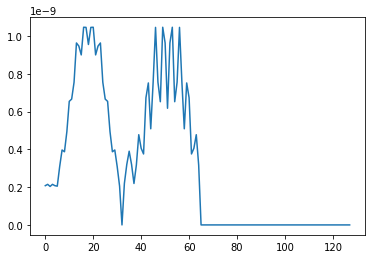

In [49]:
plt.plot(np.real(t.c.host()).ravel());

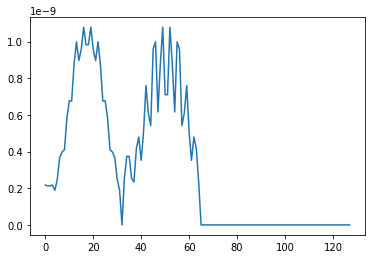

In [50]:
plt.plot(np.imag(t.c.host()).ravel());

In [51]:
t.xi.host()

array([[48, 47, 46, 45, 41, 40, 39, 38, 34, 33, 32, 31, 27, 26, 25, 24]],
      dtype=int32)

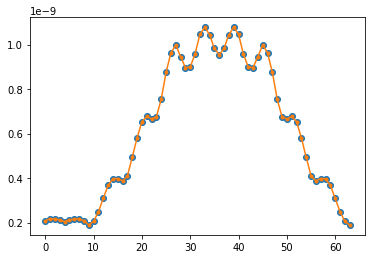

In [52]:
q = np.zeros(64)
plt.plot(np.real(yp_a)*t.NDFT,'o')
q[::2] = np.real(t.c.host()).ravel()[:32]
q[1::2] = np.imag(t.c.host()).ravel()[:32]
plt.plot(q,'.-')

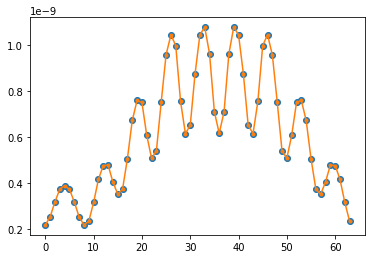

In [53]:
q = np.zeros(64)
plt.plot(np.real(yp_b)*t.NDFT,'o')
q[::2] = np.real(t.c.host()).ravel()[33:65]
q[1::2] = np.imag(t.c.host()).ravel()[33:65]
plt.plot(q,'.-')

In [54]:
y = t.MVM(u.ravel(),step=5)

In [55]:
y.host().ravel()

array([2.2875594e-11, 2.6536124e-11, 2.9177348e-11, 3.0264069e-11,
       2.9036464e-11, 3.1699792e-11, 3.2676011e-11, 3.1677692e-11,
       3.1677692e-11, 3.2676011e-11, 3.1699796e-11, 2.9036469e-11,
       3.0264069e-11, 2.9177348e-11, 2.6536127e-11, 2.2875596e-11,
       2.2875596e-11, 2.9036464e-11, 3.1677692e-11, 3.0264069e-11,
       2.6536126e-11, 3.1699792e-11, 3.2676011e-11, 2.9177348e-11,
       2.9177348e-11, 3.2676011e-11, 3.1699796e-11, 2.6536127e-11,
       3.0264069e-11, 3.1677692e-11, 2.9036469e-11, 2.2875596e-11],
      dtype=float32)

In [56]:
y0.ravel()

array([1.17952280e-11, 1.36826887e-11, 1.50445698e-11, 1.56049132e-11,
       1.49719299e-11, 1.63452064e-11, 1.68485711e-11, 1.63338093e-11,
       1.63338093e-11, 1.68485694e-11, 1.63452082e-11, 1.49719299e-11,
       1.56049132e-11, 1.50445715e-11, 1.36826904e-11, 1.17952297e-11,
       1.17952280e-11, 1.49719282e-11, 1.63338093e-11, 1.56049115e-11,
       1.36826895e-11, 1.63452082e-11, 1.68485711e-11, 1.50445715e-11,
       1.50445698e-11, 1.68485694e-11, 1.63452082e-11, 1.36826895e-11,
       1.56049115e-11, 1.63338093e-11, 1.49719299e-11, 1.17952297e-11],
      dtype=float32)

In [57]:
y.host().ravel()/y0.ravel()

array([1.939394 , 1.939394 , 1.939394 , 1.9393936, 1.9393935, 1.9393938,
       1.9393936, 1.939394 , 1.939394 , 1.9393938, 1.9393938, 1.9393939,
       1.9393936, 1.9393938, 1.939394 , 1.9393938, 1.9393941, 1.9393938,
       1.939394 , 1.9393939, 1.939394 , 1.9393936, 1.9393936, 1.9393938,
       1.939394 , 1.9393938, 1.9393938, 1.9393941, 1.9393939, 1.939394 ,
       1.9393939, 1.9393938], dtype=float32)